### Questo notebook implementa un Convolutional Neural Network che utilizza, però, i vettori pretrainati. Questi sono comunque soggetti a fine-tuning nel layer "Embeddings" col parametro trainable = True

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import gensim
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases
from nltk import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim.downloader as api
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from preprocessing import *

In [2]:
w2v_model = Word2Vec.load("w2vPreTrained")

In [3]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(subset = "verified_reviews", inplace = True)
print(dataset.shape)

(3150, 6)
(3150, 6)
(2998, 6)
(2196, 6)


In [4]:
print(dataset["feedback"].value_counts())

1    1990
0     206
Name: feedback, dtype: int64


In [5]:
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 412, 0: 206})


In [7]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [8]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, False, 2)

total number of types extracted is: 1788


In [9]:
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)

In [10]:
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)

In [12]:
negative_reviews = []
for rev, label in zip(X_train, Y_train):
    if label == 0:
        negative_reviews.append(rev)
    
generated_reviews = generate_samples(negative_reviews, int(len(negative_reviews)/2), w2v_model)

# run this only one time
X_train.extend(generated_reviews)
Y_train.extend([0 for x in generated_reviews])

['joke']
-
['laugh']
--------------------------
['price', 'product', 'nice', 'quality', 'nice', 'feature', 'definitely', 'reason', 'give', 'think', 'may', 'buyer', 'error', 'first', 'ignore', 'product', 'plug', 'time', 'work', 'really', 'unlike', 'not_a', 'stand', 'device', 'also', 'speaker', 'not_very', 'loud', 'buy', 'bluetooth', 'speaker', 'sure', 'lot', 'figure', 'use', 'kind', 'seem', 'like', 'device', 'plus', 'set', 'awful', 'would', 'definitely', 'money', 'buy', 'one', 'actually']
-
['cost', 'product', 'decent', 'quality', 'decent', 'feature', 'definitely', 'reason', 'present', 'imagine', 'may', 'buyer', 'error', 'start', 'ignore', 'product', 'plug', 'sentence', 'run', 'truly', 'different', 'not_a', 'base', 'device', 'also', 'speaker', 'not_very', 'loudly', 'purchase', 'bluetooth', 'speaker', 'sure', 'plenty', 'figure', 'utilize', 'kind', 'seem', 'wish', 'device', 'plus', 'adjust', 'terrible', 'would', 'definitely', 'money', 'purchase', 'one', 'really']
-------------------------

In [13]:
print('Train set is %s' % Counter(Y_train))
print('Test set is %s' % Counter(Y_test))

Train set is Counter({1: 329, 0: 241})
Test set is Counter({1: 83, 0: 41})


In [14]:
t = Tokenizer(lower = False)
t.fit_on_texts(X_train)
X_train_encoded = t.texts_to_sequences(X_train)
max_length = len(max(bigrams[cleaned_reviews], key = len))
Xtrain = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')

In [15]:
X_test_encoded = t.texts_to_sequences(X_test)
Xtest = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

In [16]:
vocab_size = len(t.word_index) + 1

In [17]:
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, w2v_model.vector_size))
    # step vocab, store vectors using the Tokenizer's integer mapping
    not_found = 0
    not_found_list = []
    for word, i in vocab.items():
        try:
            vector = embedding[word]
            weight_matrix[i] = vector
        except KeyError:
            weight_matrix[i] = np.zeros((1, w2v_model.vector_size))
            not_found+=1
            not_found_list.append(word)
            continue

    print(not_found_list)
    print(not_found)
    return weight_matrix

In [18]:
embedding_weights = get_weight_matrix(w2v_model.wv, t.word_index)

['play_music', 'not_a', 'differ', 'sound_quality', 'not_the', 'send_back', 'still_learn', 'listen_music', 'light_bulb', "'ve", 'even_though', "'re", 'uncertain', 'answer_question', 'play_radio', 'homescreen', 'unmake', 'look_forward', 'not_very', 'unretentive', 'not_that', 'video_chat', 'alarm_clock', 'forbid', 'not_this', 'make_life', "'ll", 'not_i', 'unaware', 'trailer', 'certified', 'not_to', 'excitement', 'not_it']
34


In [19]:
from keras.layers import Flatten

In [20]:
from keras.utils import to_categorical
Y_train_hot = to_categorical(Y_train)

In [21]:
print(Y_train[0], Y_train_hot[0])
print(Y_train[1], Y_train_hot[1])

1 [0. 1.]
0 [1. 0.]


In [22]:
Y_test_hot = to_categorical(Y_test)

In [23]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Embedding, Conv1D, MaxPooling1D

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='binary_accuracy', patience=25)

model = Sequential()
model.add(Embedding(vocab_size, w2v_model.vector_size, input_length=max_length, trainable = True, weights = [embedding_weights]))
model.add(Dropout(0.2))
model.add(Conv1D(filters=16, kernel_size=10, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          70100     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 91, 16)            16016     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 45, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dropout_1 (Dropout)         (None, 720)               0         
                                                        

In [24]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
# fit network
# # better to fit multiple times
# model.fit(Xtrain, Y_train_hot, epochs=50, verbose=2, validation_split=0.2, callbacks=[early_stopping], batch_size=4)

In [25]:
from sklearn.model_selection import KFold

def fit_and_evaluate(model, X, y, epochs=100):
    model.fit(X, y,epochs=epochs, batch_size=16, verbose=2, validation_split=0.2, callbacks = [early_stopping])
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

# Initialize the KFold object
kfold = KFold(n_splits=5, shuffle=True)

# Loop over the folds and fit/evaluate the model
accuracies = []
for train_index, val_index in kfold.split(Xtrain):
    X_train, X_val = Xtrain[train_index], Xtrain[val_index]
    y_train, y_val = Y_train_hot[train_index], Y_train_hot[val_index]
    accuracy = fit_and_evaluate(model, X_train, y_train)
    accuracies.append(accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print('Mean accuracy:', mean_accuracy)

Epoch 1/100
23/23 - 2s - loss: 0.6848 - binary_accuracy: 0.6305 - val_loss: 0.9191 - val_binary_accuracy: 0.2609 - 2s/epoch - 85ms/step
Epoch 2/100
23/23 - 0s - loss: 0.5734 - binary_accuracy: 0.7184 - val_loss: 0.8517 - val_binary_accuracy: 0.4348 - 330ms/epoch - 14ms/step
Epoch 3/100
23/23 - 0s - loss: 0.4284 - binary_accuracy: 0.7953 - val_loss: 0.6570 - val_binary_accuracy: 0.6359 - 328ms/epoch - 14ms/step
Epoch 4/100
23/23 - 0s - loss: 0.2526 - binary_accuracy: 0.8956 - val_loss: 0.5417 - val_binary_accuracy: 0.7935 - 331ms/epoch - 14ms/step
Epoch 5/100
23/23 - 0s - loss: 0.1548 - binary_accuracy: 0.9327 - val_loss: 0.7569 - val_binary_accuracy: 0.7554 - 331ms/epoch - 14ms/step
Epoch 6/100
23/23 - 0s - loss: 0.1467 - binary_accuracy: 0.9451 - val_loss: 0.4716 - val_binary_accuracy: 0.8152 - 336ms/epoch - 15ms/step
Epoch 7/100
23/23 - 0s - loss: 0.1173 - binary_accuracy: 0.9629 - val_loss: 1.2701 - val_binary_accuracy: 0.7011 - 331ms/epoch - 14ms/step
Epoch 8/100
23/23 - 0s - loss:

In [26]:
predictions = model.predict(Xtest)

4/4 [==============================] - 0s 4ms/step


In [27]:
predictions.shape

(124, 2)

In [28]:
predictions = np.round(predictions)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_hot, predictions))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        41
           1       0.90      0.92      0.91        83

   micro avg       0.88      0.88      0.88       124
   macro avg       0.86      0.86      0.86       124
weighted avg       0.88      0.88      0.88       124
 samples avg       0.88      0.88      0.88       124



In [33]:
rep_dict = classification_report(Y_test_hot, predictions, output_dict=True)

print(pd.DataFrame(rep_dict).T.to_latex(bold_rows = True, float_format="%.2f" ))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{0           } &       0.82 &    0.80 &      0.81 &    41.00 \\
\textbf{1           } &       0.90 &    0.92 &      0.91 &    83.00 \\
\textbf{micro avg   } &       0.88 &    0.88 &      0.88 &   124.00 \\
\textbf{macro avg   } &       0.86 &    0.86 &      0.86 &   124.00 \\
\textbf{weighted avg} &       0.88 &    0.88 &      0.88 &   124.00 \\
\textbf{samples avg } &       0.88 &    0.88 &      0.88 &   124.00 \\
\bottomrule
\end{tabular}



C:\Users\crist\AppData\Local\Temp\ipykernel_3452\4095485670.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(rep_dict).T.to_latex(bold_rows = True, float_format="%.2f" ))


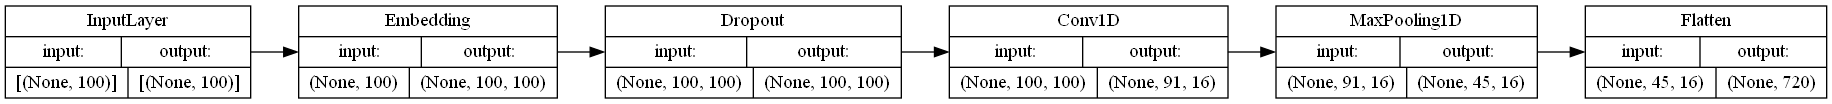

In [46]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_test.png', show_shapes=True, rankdir="LR", layer_range=["embedding", "dropout_1"], show_layer_names=False)

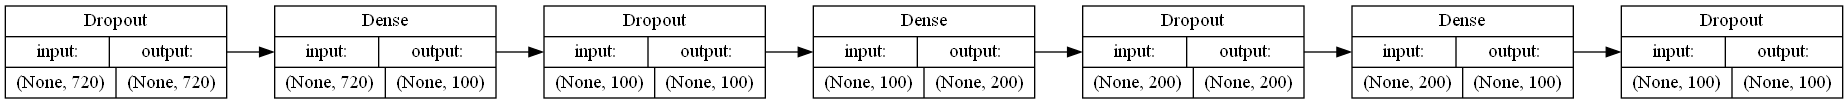

In [55]:
plot_model(model, to_file='model_test.png', show_shapes=True, rankdir="LR", layer_range=["dense", "dense_3"], show_layer_names=False)

In [30]:
x = ["Awful, the sound is terrible and it doesn't understand me"]
review, temp = tokenize_list_of_text(x, custom_stopwords, False, 2)
print(temp)
seq_review = t.texts_to_sequences(temp)
padded_review = pad_sequences(seq_review, maxlen=max_length, padding='post')
preds = np.round(model.predict(padded_review))
preds

total number of types extracted is: 4
[['awful', 'sound', 'terrible', 'not_understand']]
1/1 [==============================] - 0s 25ms/step


array([[1., 0.]], dtype=float32)

In [31]:
model.predict(padded_review)

1/1 [==============================] - 0s 24ms/step


array([[0.9984378 , 0.00148084]], dtype=float32)

In [32]:
# [1, 0] is equal to negative label